# Stack Model & Perturb-Sapiens Exploration
Run on HPC with A100 GPU. Designed for limited storage.

In [7]:
import sys
import os

# Install to user directory
!pip install --user --quiet arc-stack scanpy huggingface_hub umap-learn matplotlib

# Add to path
user = os.environ.get('USER')
sys.path.insert(0, f"/home/{user}/.local/lib/python3.10/site-packages")

print("Done!")



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Done!


In [8]:
# Cell 2: Check GPU
import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")
print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB" if torch.cuda.is_available() else "")

GPU available: True
GPU name: NVIDIA A100-SXM4-80GB
GPU memory: 85.1 GB


In [9]:
# Cell 3: Download ONE small example file (~500MB)
# Using tempdir to avoid filling your home quota
import tempfile
import os
from huggingface_hub import hf_hub_download

# Use temp directory (cleaned up when session ends)
TEMP_DIR = tempfile.mkdtemp()
print(f"Using temp directory: {TEMP_DIR}")

# Download ADSF cytokine example
print("Downloading Perturb-Sapiens example (ADSF cytokine)...")
data_path = hf_hub_download(
    repo_id="arcinstitute/Perturb-Sapiens",
    filename="PerturbSapiensv1/cytokine/ADSF.h5ad",
    repo_type="dataset",
    cache_dir=TEMP_DIR
)
print(f"Downloaded to: {data_path}")
print(f"File size: {os.path.getsize(data_path) / 1e6:.1f} MB")

Using temp directory: /tmp/tmp34o3ftka


ADSF.h5ad:   0%|          | 0.00/6.80G [00:00<?, ?B/s]

Downloaded to: /tmp/tmp34o3ftka/datasets--arcinstitute--Perturb-Sapiens/snapshots/4833fc50a55eca2a1564b6d4ea66966a32880a5c/PerturbSapiensv1/cytokine/ADSF.h5ad
File size: 6802.9 MB


In [10]:
# Cell 4: Load and explore the data
import scanpy as sc

adata = sc.read_h5ad(data_path)
print(f"\n=== Dataset Overview ===")
print(f"Cells: {adata.n_obs:,}")
print(f"Genes: {adata.n_vars:,}")
print(f"\nCell metadata columns: {list(adata.obs.columns)}")
print(f"\nGene metadata columns: {list(adata.var.columns)}")


=== Dataset Overview ===
Cells: 513,870
Genes: 15,012

Cell metadata columns: ['donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'sample_number', 'suspension_type', 'tissue_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stag

In [11]:
# Cell 5: Look at cell types and tissues
print("=== Cell Types ===")
if 'cell_type' in adata.obs.columns:
    print(adata.obs['cell_type'].value_counts().head(20))
elif 'cell_ontology_class' in adata.obs.columns:
    print(adata.obs['cell_ontology_class'].value_counts().head(20))

print("\n=== Tissues ===")
if 'tissue' in adata.obs.columns:
    print(adata.obs['tissue'].value_counts())

=== Cell Types ===
cell_type
fibroblast                                     38208
CD8-positive, alpha-beta T cell                32254
CD4-positive, alpha-beta T cell                31797
B cell                                         30852
macrophage                                     29832
neutrophil                                     26239
basal cell                                     20543
endothelial cell                               19929
stromal cell of ovary                          14239
plasma cell                                    12130
luminal cell of prostate epithelium            10147
luminal epithelial cell of mammary gland       10030
mesenchymal stem cell                           9965
monocyte                                        9590
kidney epithelial cell                          9278
smooth muscle cell                              8974
bladder urothelial cell                         8169
cardiac endothelial cell                        7815
hepatocyte       

In [12]:
# Cell 6: Preprocess (following Perturb-Sapiens recommendations)
print("Preprocessing...")

# Normalize and log transform
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")

# Filter to HVGs for faster processing
adata_hvg = adata[:, adata.var['highly_variable']].copy()
print(f"Filtered shape: {adata_hvg.shape}")

Preprocessing...
Highly variable genes: 4000
Filtered shape: (513870, 4000)


In [24]:
# Download the correct checkpoint
checkpoint_path = hf_hub_download(
  repo_id="arcinstitute/Stack-Large",
  filename="bc_large.ckpt",
  cache_dir=TEMP_DIR
)
print(f"Downloaded to: {checkpoint_path}")

# Also download the gene list
genelist_path = hf_hub_download(
  repo_id="arcinstitute/Stack-Large",
  filename="basecount_1000per_15000max.pkl",
  cache_dir=TEMP_DIR
)
print(f"Gene list: {genelist_path}")






bc_large.ckpt:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Downloaded to: /tmp/tmp34o3ftka/models--arcinstitute--Stack-Large/snapshots/3c81ea9fbd956150048e59f4e55d4412fea3eba7/bc_large.ckpt


basecount_1000per_15000max.pkl:   0%|          | 0.00/925k [00:00<?, ?B/s]

Gene list: /tmp/tmp34o3ftka/models--arcinstitute--Stack-Large/snapshots/3c81ea9fbd956150048e59f4e55d4412fea3eba7/basecount_1000per_15000max.pkl


In [25]:
from stack.model import load_model_from_checkpoint

print("Loading Stack model...")
model = load_model_from_checkpoint(checkpoint_path, device="cuda")
model.eval()
print("Model loaded on GPU!")

Loading Stack model...


/home/mulbagal.a/.local/lib/python3.10/site-packages/stack/model_loading.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path_obj, ma

Model loaded on GPU!


In [28]:

# Check what methods are available
print("Model methods:")
print([x for x in dir(model) if not x.startswith('_') and callable(getattr(model, x))])






Model methods:
['add_module', 'apply', 'apply_mask', 'bfloat16', 'buffers', 'children', 'compile', 'cpu', 'cuda', 'decode', 'double', 'eval', 'extra_repr', 'float', 'forward', 'gene_reduction', 'get_attn', 'get_buffer', 'get_extra_state', 'get_incontext_attn', 'get_incontext_generation', 'get_incontext_prediction', 'get_latent_representation', 'get_parameter', 'get_prediction', 'get_submodule', 'half', 'ipu', 'layers', 'load_state_dict', 'modules', 'mtia', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'output_mlp', 'parameters', 'predict', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_full_backward_pre_hook', 'register_load_state_dict_post_hook', 'register_load_state_dict_pre_hook', 'register_module', 'register_parameter', 'register_state_dict_post_hook', 'register_state_dict_pre_hook', 'requires_grad_', 'set_extra_state', 'set_submodule', 'share_memory', 'state_dict'

In [29]:
import pickle

# Load gene list
with open(genelist_path, 'rb') as f:
  gene_list = pickle.load(f)
print(f"Gene list has {len(gene_list)} genes")

# Check overlap with our data
common_genes = set(adata.var_names) & set(gene_list)
print(f"Common genes with data: {len(common_genes)}")

Gene list has 15012 genes
Common genes with data: 15012


In [30]:
import inspect

# Check the signature
print("get_latent_representation signature:")
print(inspect.signature(model.get_latent_representation))

# Also check forward method
print("\nforward signature:")
print(inspect.signature(model.forward))



get_latent_representation signature:
(adata_path, genelist_path, gene_name_col: 'Optional[str]' = None, batch_size: 'int' = 32, show_progress: 'bool' = True, num_workers: 'int' = 4, **dataloader_kwargs) -> 'np.ndarray'

forward signature:
(features: 'torch.Tensor', return_loss: 'bool' = True) -> 'Dict[str, torch.Tensor]'


In [31]:
# Generate embeddings using the model
print("Generating embeddings...")
embeddings = model.get_latent_representation(
  adata_path=data_path,
  genelist_path=genelist_path,
  batch_size=32,
  show_progress=True
)



'organism' column not found, assuming all cells are valid


Generating embeddings...


Extracting embeddings:   0%|          | 0/63 [00:00<?, ?batch/s]

AttributeError: 'tuple' object has no attribute 'shape'

In [32]:
# Check what's in the tuple
print(f"Return type: {type(embeddings)}")
print(f"Number of elements: {len(embeddings)}")
for i, item in enumerate(embeddings):
  if hasattr(item, 'shape'):
      print(f"  [{i}] shape: {item.shape}")
  else:
      print(f"  [{i}] type: {type(item)}, len: {len(item) if hasattr(item, '__len__') else 'N/A'}")

Return type: <class 'tuple'>
Number of elements: 2
  [0] shape: (513870, 1600)
  [1] shape: (514048,)


In [33]:
# Unpack
cell_embeddings, cell_indices = embeddings
print(f"Cell embeddings: {cell_embeddings.shape}")  # (513870, 1600)

# Add to adata and visualize with UMAP
import scanpy as sc

# Reload adata fresh (we need it to match embedding size)
adata = sc.read_h5ad(data_path)

# The embeddings might have filtered some cells - subset adata to match
# cell_indices likely tells us which cells were kept
print(f"Original cells: {adata.n_obs}")
print(f"Embedded cells: {cell_embeddings.shape[0]}")

# Subset adata to embedded cells if needed
if cell_embeddings.shape[0] < adata.n_obs:
  adata = adata[cell_indices].copy()

# Add embeddings
adata.obsm['X_stack'] = cell_embeddings
print(f"Added embeddings to adata.obsm['X_stack']")

Cell embeddings: (513870, 1600)
Original cells: 513870
Embedded cells: 513870
Added embeddings to adata.obsm['X_stack']


In [34]:
# Compute UMAP on Stack embeddings
print("Computing neighbors...")
sc.pp.neighbors(adata, use_rep='X_stack', n_neighbors=15)

print("Computing UMAP...")
sc.tl.umap(adata)

print("Done! Plotting...")

# Check what metadata columns we have
print("Available columns:", list(adata.obs.columns))


Computing neighbors...


2026-01-11 19:58:49.069695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768179529.330935 1786958 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768179529.397295 1786958 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768179530.036215 1786958 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768179530.036255 1786958 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768179530.036257 1786958 computation_placer.cc:177] computation placer alr

Computing UMAP...
Done! Plotting...
Available columns: ['donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'sample_number', 'suspension_type', 'tissue_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'

/tmp/ipykernel_1786958/846312196.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


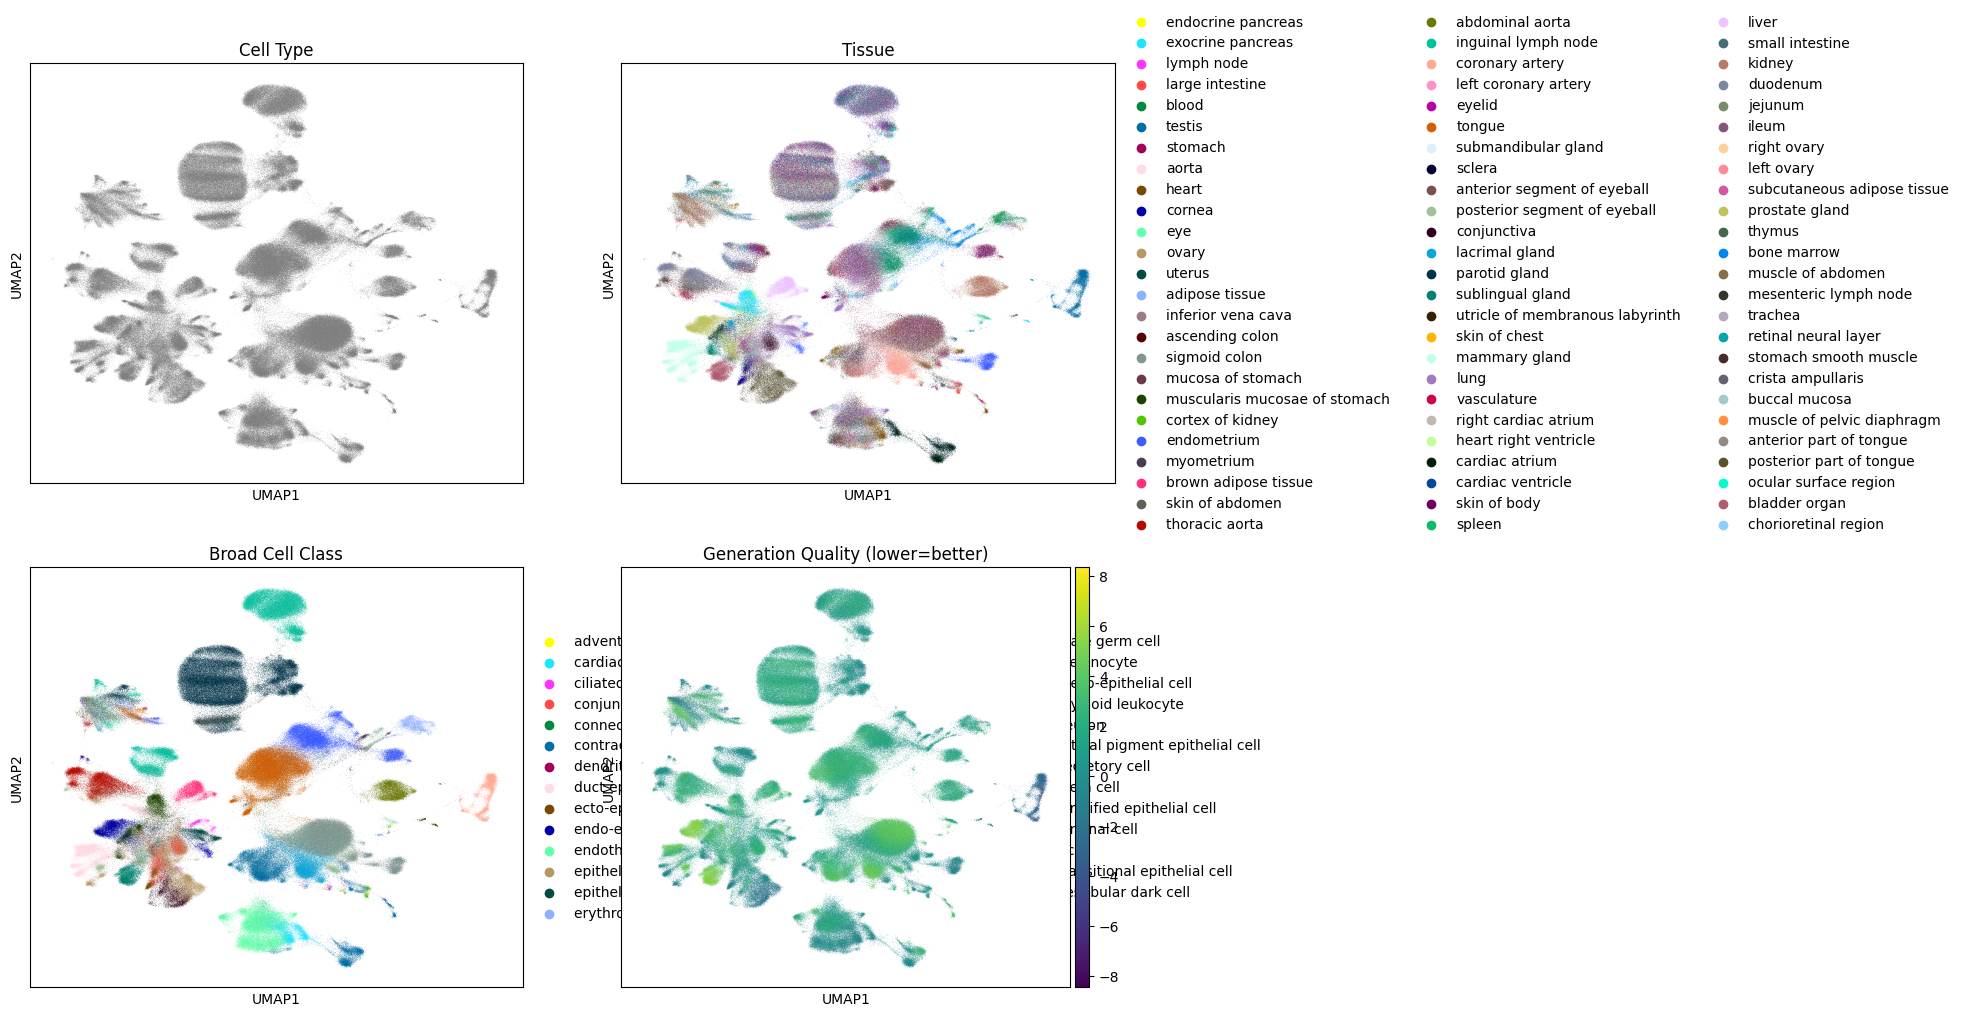


Saved to stack_umap.png


In [35]:
import matplotlib.pyplot as plt

# Create figure with multiple plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sc.pl.umap(adata, color='cell_type', ax=axes[0,0], show=False, title='Cell Type', legend_loc='none')
sc.pl.umap(adata, color='tissue', ax=axes[0,1], show=False, title='Tissue')
sc.pl.umap(adata, color='broad_cell_class', ax=axes[1,0], show=False, title='Broad Cell Class')
sc.pl.umap(adata, color='gen_logit', ax=axes[1,1], show=False, title='Generation Quality (lower=better)')

plt.tight_layout()
plt.savefig('stack_umap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved to stack_umap.png")



In [36]:

# Download PBS control
print("Downloading PBS control...")
pbs_path = hf_hub_download(
  repo_id="arcinstitute/Perturb-Sapiens",
  filename="PerturbSapiensv1/cytokine/PBS.h5ad",
  repo_type="dataset",
  cache_dir=TEMP_DIR
)
print(f"Downloaded: {os.path.getsize(pbs_path) / 1e6:.1f} MB")

PBS.h5ad:   0%|          | 0.00/6.80G [00:00<?, ?B/s]

Downloaded: 6796.1 MB


In [37]:
# Generate embeddings for PBS control
print("Generating PBS embeddings...")
pbs_embeddings = model.get_latent_representation(
  adata_path=pbs_path,
  genelist_path=genelist_path,
  batch_size=32,
  show_progress=True
)
pbs_cell_embeddings, pbs_cell_indices = pbs_embeddings
print(f"PBS embeddings: {pbs_cell_embeddings.shape}")

'organism' column not found, assuming all cells are valid


Generating PBS embeddings...


Extracting embeddings:   0%|          | 0/63 [00:01<?, ?batch/s]

PBS embeddings: (513870, 1600)


In [40]:

import numpy as np

# Load PBS adata and add embeddings
pbs_adata = sc.read_h5ad(pbs_path)
pbs_adata.obsm['X_stack'] = pbs_cell_embeddings

# Add condition labels
adata.obs['condition'] = 'ADSF'
pbs_adata.obs['condition'] = 'PBS_control'

# Combine the two datasets
print("Combining datasets...")
combined = sc.concat([adata, pbs_adata], label='condition', keys=['ADSF', 'PBS'])
combined.obsm['X_stack'] = np.vstack([adata.obsm['X_stack'], pbs_adata.obsm['X_stack']])
print(f"Combined: {combined.n_obs} cells")



Combining datasets...


/home/mulbagal.a/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Combined: 1027740 cells


Computing joint UMAP...


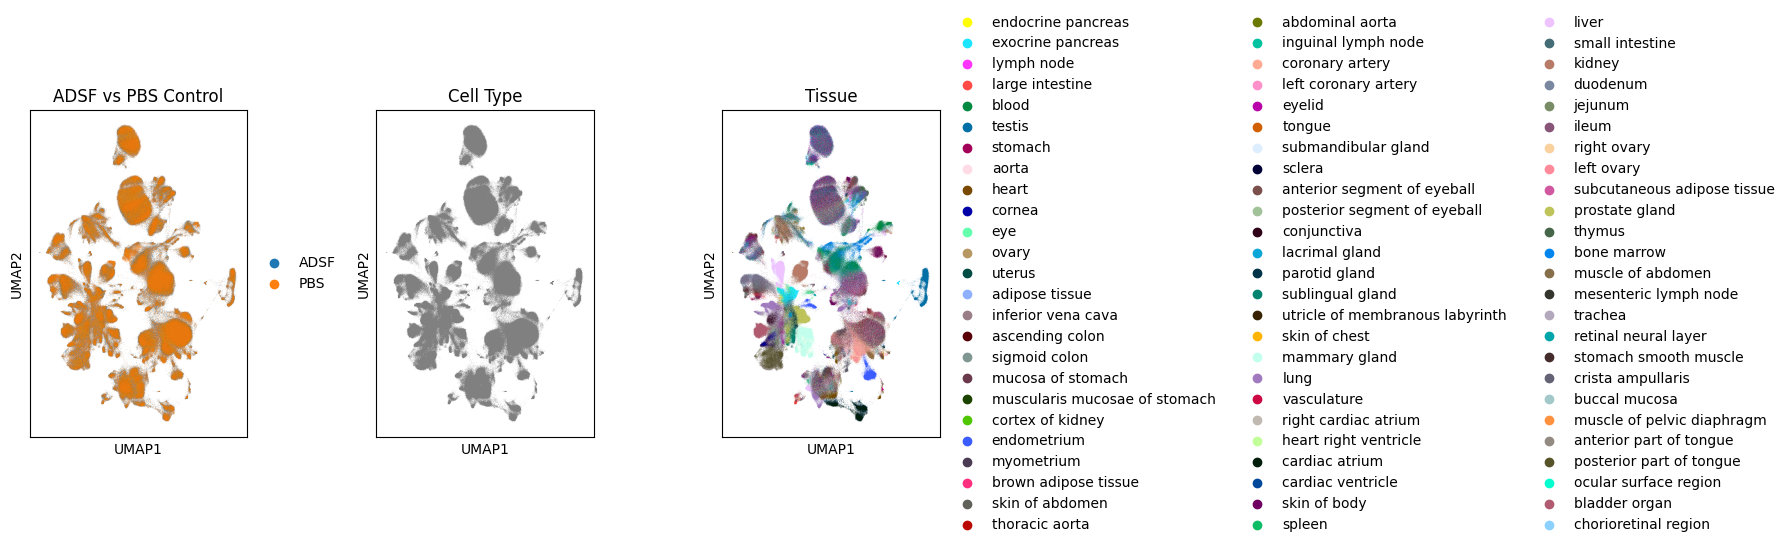

In [41]:
# Compute joint UMAP
import numpy as np

print("Computing joint UMAP...")
sc.pp.neighbors(combined, use_rep='X_stack', n_neighbors=15)
sc.tl.umap(combined)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(combined, color='condition', ax=axes[0], show=False, title='ADSF vs PBS Control')
sc.pl.umap(combined, color='cell_type', ax=axes[1], show=False, title='Cell Type', legend_loc='none')
sc.pl.umap(combined, color='tissue', ax=axes[2], show=False, title='Tissue')

plt.tight_layout()
plt.savefig('adsf_vs_pbs.png', dpi=150, bbox_inches='tight')
plt.show()